# Predicting the Opening Weekend Gross using Linear Regression Modeling

## Part 2 - Data Cleaning, Exploration & String Imputation

This is the second notebook as part of my project. 
It deals with cleaning the scraped data, exploring it and imputing the string columns.

In [75]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import random
import time
import pickle
import sys
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(context='notebook', style='darkgrid', font_scale=1.05)


### Loading & Modifying the DataFrame to Include additional columns

In [76]:
df_movies = pd.read_csv('Movies_listv3.csv',parse_dates=[7])

df_movies.rename(columns={'Franchise Ranking':'Franchise','Brand Ranking':'Brand'},inplace=True)

print(df_movies.shape)
print(df_movies.columns)


#Target Variable
y = 'Opening Weekend Gross'

#column list with target column at the end
cols_list = df_movies.drop(columns=y).columns.tolist()+[y]
cols_list

(6280, 17)
Index(['Release Link', 'Title', 'Domestic Gross', 'Max Theatres',
       'Opening Weekend Gross', 'Domestic to Opening Gross',
       'Opening Weekend Theatres', 'Release Date', 'Studio Link',
       'Studio Name', 'Title ID', 'Running Length', 'Budget', 'MPAA', 'Genre',
       'Franchise', 'Brand'],
      dtype='object')


['Release Link',
 'Title',
 'Domestic Gross',
 'Max Theatres',
 'Domestic to Opening Gross',
 'Opening Weekend Theatres',
 'Release Date',
 'Studio Link',
 'Studio Name',
 'Title ID',
 'Running Length',
 'Budget',
 'MPAA',
 'Genre',
 'Franchise',
 'Brand',
 'Opening Weekend Gross']

---
## Exploratory Data Analysis & Cleaning

In [49]:
df_movies.describe()

,Domestic Gross,Opening Weekend Gross,Domestic to Opening Gross,Running Length,Budget,Franchise,Brand
count,6.280000e+03,6.280000e+03,6280.000000,6098.000000,2.426000e+03,6280.000000,6280.000000
mean,1.727190e+07,5.205487e+06,0.283905,105.553460,3.538708e+07,0.067834,0.064331
std,5.493935e+07,1.787751e+07,0.236398,30.444267,5.013210e+07,0.251482,0.245362
min,7.200000e+01,0.000000e+00,0.000000,61.000000,0.000000e+00,0.000000,0.000000
25%,2.502400e+04,4.755500e+03,0.074000,91.000000,4.500000e+06,0.000000,0.000000
50%,1.841175e+05,2.409600e+04,0.259000,101.000000,1.500000e+07,0.000000,0.000000
75%,3.705458e+06,5.050545e+05,0.430000,114.000000,4.000000e+07,0.000000,0.000000
max,9.366622e+08,3.571150e+08,1.891000,1179.000000,3.560000e+08,1.000000,1.000000


In [77]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6280 entries, 0 to 6279
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Release Link               6280 non-null   object        
 1   Title                      6280 non-null   object        
 2   Domestic Gross             6280 non-null   int64         
 3   Max Theatres               6280 non-null   object        
 4   Opening Weekend Gross      6280 non-null   int64         
 5   Domestic to Opening Gross  6280 non-null   float64       
 6   Opening Weekend Theatres   6280 non-null   object        
 7   Release Date               6280 non-null   datetime64[ns]
 8   Studio Link                6280 non-null   object        
 9   Studio Name                6280 non-null   object        
 10  Title ID                   6260 non-null   object        
 11  Running Length             6098 non-null   float64       
 12  Budget

----
Based on the above tables, 
The max **running length** of a movie is ***1179 minutes***, which does not seem plausible. This merits further exploring.  
**Budget** maximum is magnitudes higher than the 75% mark.
Additionally, there are a lot of **missing values** for **Budget & MPAA** & a few for **Running Length & Genre**

Lastly, **Opening Weekend Theatres** are being read as **object** columns, whereas they should be integers. This requires some data cleaning!


### Opening Weekend Theatres

Let's see if there are non-numeric values in the 'Opening Weekend Theatres' column.
Based on the return type & quantity, these rows can possibly be dropped

In [78]:
mask_non_numeric_theatres = ~(df_movies['Opening Weekend Theatres'].str.isnumeric())
df_movies_non_numeric_theatres = df_movies[mask_non_numeric_theatres]
print(df_movies_non_numeric_theatres.shape)
df_movies_non_numeric_theatres.sort_values(by='Budget',ascending=False).head()

(486, 17)


,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
4759,https://www.boxofficemojo.com//release/rl20168...,The Polar Express2017 IMAX Release,875150,-,1321,0.002,-,2017-11-17,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
2207,https://www.boxofficemojo.com//release/rl35904...,The Polar Express2013 IMAX Release,493776,-,0,0.000,-,2013-11-09,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
2856,https://www.boxofficemojo.com//release/rl36072...,The Polar Express2014 IMAX Release,139055,-,0,0.000,-,2014-11-01,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
4150,https://www.boxofficemojo.com//release/rl35233...,The Polar Express2016 IMAX Release,765154,129,0,0.000,-,2016-11-11,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
3480,https://www.boxofficemojo.com//release/rl33555...,The Polar Express2015 IMAX Release,846602,-,0,0.000,-,2015-11-19,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0


Since Opening Weekend Theatres is a vital to predicting how much a movie would make in its Opening Weekend, the 486 rows without this information will be dropped.

Also, looks like the top few budget movies with no 'Opening Weekend Theatres' are IMAX releases and/or re-releases. It would be prudent to remove any movie title with the word 'release' or 'IMAX' in it, as re-releases are outside the scope of this project.

In [79]:
df_movies = df_movies.drop(df_movies_non_numeric_theatres.index).reset_index(drop = True)
df_movies['Opening Weekend Theatres'] = df_movies['Opening Weekend Theatres'].astype('int64')
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5794 entries, 0 to 5793
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Release Link               5794 non-null   object        
 1   Title                      5794 non-null   object        
 2   Domestic Gross             5794 non-null   int64         
 3   Max Theatres               5794 non-null   object        
 4   Opening Weekend Gross      5794 non-null   int64         
 5   Domestic to Opening Gross  5794 non-null   float64       
 6   Opening Weekend Theatres   5794 non-null   int64         
 7   Release Date               5794 non-null   datetime64[ns]
 8   Studio Link                5794 non-null   object        
 9   Studio Name                5794 non-null   object        
 10  Title ID                   5781 non-null   object        
 11  Running Length             5648 non-null   float64       
 12  Budget

Looks like 'Opening Weekend Theatres' column was successfully changed to an integer format. 

In [80]:
#dropping movies with "Release" in their title"
df_movies[df_movies.Title.str.contains('Release|IMAX',case=False,regex=True)]

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
195,https://www.boxofficemojo.com//release/rl51036...,The Polar Express2010 IMAX Release,672796,17,80505,0.120,15,2010-12-03,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
497,https://www.boxofficemojo.com//release/rl37139...,The Lion King2011 3D Release,94242001,2340,30151614,0.320,2330,2011-09-16,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt0110357,88.0,45000000.0,['G'],"['Adventure', 'Animation', 'Drama', 'Family', ...",0.0,0.0
706,https://www.boxofficemojo.com//release/rl52714...,The Polar Express2011 IMAX Release,711168,25,55299,0.078,19,2011-11-25,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
1034,https://www.boxofficemojo.com//release/rl13496...,Star Wars: Episode I - The Phantom Menace2012 ...,43456382,2655,22469932,0.517,2655,2012-02-10,https://pro.imdb.com/company/co0000756/boxoffi...,Twentieth Century Fox,tt0120915,136.0,115000000.0,['PG'],"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",1.0,1.0
1048,https://www.boxofficemojo.com//release/rl25614...,Beauty and the Beast2012 3D Release,47617067,2625,17751905,0.373,2625,2012-01-13,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt0101414,84.0,25000000.0,NaN,"['Animation', 'Family', 'Fantasy', 'Musical', ...",0.0,0.0
1052,https://www.boxofficemojo.com//release/rl37154...,Titanic2012 3D Release,57884114,3674,17285453,0.299,2674,2012-04-04,https://pro.imdb.com/company/co0023400/boxoffi...,Paramount Pictures,tt0120338,194.0,200000000.0,['PG-13'],"['Drama', 'Romance']",0.0,0.0
1054,https://www.boxofficemojo.com//release/rl27066...,Finding Nemo2012 3D Release,41128283,2904,16687773,0.406,2904,2012-09-14,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt0266543,100.0,94000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family']",1.0,1.0
1106,https://www.boxofficemojo.com//release/rl20366...,"Monsters, Inc.2012 3D Release",34043006,2618,4774686,0.140,2618,2012-12-19,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt0198781,92.0,115000000.0,['G'],"['Adventure', 'Animation', 'Comedy', 'Family',...",1.0,1.0
1126,https://www.boxofficemojo.com//release/rl40670...,Raiders of the Lost Ark2012 IMAX Release,3125613,322,1673731,0.535,267,2012-09-07,https://pro.imdb.com/company/co0023400/boxoffi...,Paramount Pictures,tt0082971,115.0,18000000.0,['PG'],"['Action', 'Adventure']",1.0,1.0
1216,https://www.boxofficemojo.com//release/rl27548...,The Polar Express2012 IMAX Release,669289,17,73514,0.110,15,2012-11-21,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0


All of the above movies are "Re-releases" of existing movies. Hence they will be dropped from the dataset.

In [81]:
df_movies = df_movies.drop(df_movies[df_movies.Title.str.contains('Release|IMAX',case=False,regex=True)].index).reset_index(drop=True)

----
### Budget

Since Budget accounts for the largest # of missing values, we can examine this to see if we want drop rows or keep, and proceed accordingly. 

In [82]:
mask_budget_na = (df_movies.Budget.isna()) | (df_movies.Budget==0)
df_movies[mask_budget_na].describe()

,Domestic Gross,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Running Length,Budget,Franchise,Brand
count,3.444000e+03,3.444000e+03,3444.000000,3444.000000,3337.000000,1.0,3444.000000,3444.000000
mean,6.400839e+05,1.344683e+05,0.300714,50.623403,104.487264,0.0,0.006388,0.014228
std,2.325289e+06,6.486394e+05,0.248728,198.214474,30.475664,NaN,0.079680,0.118445
min,7.200000e+01,0.000000e+00,0.000000,1.000000,61.000000,0.0,0.000000,0.000000
25%,1.729775e+04,4.519500e+03,0.093000,1.000000,90.000000,0.0,0.000000,0.000000
50%,6.834600e+04,1.187700e+04,0.232000,3.000000,99.000000,0.0,0.000000,0.000000
75%,3.394680e+05,4.815175e+04,0.465250,14.000000,112.000000,0.0,0.000000,0.000000
max,5.252290e+07,2.164168e+07,1.891000,3020.000000,808.000000,0.0,1.000000,1.000000


Based on the above table, looks like atleast 75% of the movies with no budget info were released in 14 theatres or less & made less than 48000 on opening weekend, indicating they are very niche movies. 

In [83]:
mask_budget_na = ((df_movies.Budget.isna()) | (df_movies.Budget==0)) & (df_movies['Opening Weekend Theatres'] > 14)
df_movies[mask_budget_na].sort_values(by='Opening Weekend Theatres',ascending=False)

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
2833,https://www.boxofficemojo.com//release/rl22560...,Strange Magic,12429583,3020,5504441,0.443,3020,2015-01-23,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt4191054,99.0,NaN,['PG'],"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,1.0
5291,https://www.boxofficemojo.com//release/rl53723...,Arctic Dogs,5801249,2844,2901335,0.500,2844,2019-11-01,https://pro.imdb.com/company/co0608498/boxoffi...,Entertainment Studios Motion Pictures,tt4426464,92.0,NaN,['PG'],"['Adventure', 'Animation', 'Comedy', 'Family']",0.0,0.0
3410,https://www.boxofficemojo.com//release/rl31455...,The Choice,18730891,2631,6050443,0.323,2631,2016-02-05,https://pro.imdb.com/company/co0173285/boxoffi...,Lionsgate,tt3797868,111.0,NaN,['PG-13'],"['Drama', 'Romance']",0.0,1.0
1108,https://www.boxofficemojo.com//release/rl33952...,Won't Back Down,5310554,2517,2603370,0.490,2515,2012-09-28,https://pro.imdb.com/company/co0000756/boxoffi...,Twentieth Century Fox,tt1870529,121.0,NaN,['PG'],['Drama'],0.0,1.0
5279,https://www.boxofficemojo.com//release/rl14600...,Greta,10532219,2417,4481910,0.426,2411,2019-03-01,https://pro.imdb.com/company/co0042399/boxoffi...,Focus Features,tt2639336,98.0,NaN,['R'],"['Drama', 'Mystery', 'Thriller']",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,https://www.boxofficemojo.com//release/rl71096...,"Love, Rosie",20431,15,14893,0.729,15,2015-02-06,https://pro.imdb.com/company/co0373736/boxoffi...,The Film Arcade,tt1638002,102.0,NaN,['R'],"['Comedy', 'Romance']",0.0,0.0
3070,https://www.boxofficemojo.com//release/rl17599...,Madame Bovary,44235,15,20841,0.471,15,2015-06-12,https://pro.imdb.com/company/co0140583/boxoffi...,Alchemy,tt2334733,118.0,NaN,['R'],"['Drama', 'Romance']",0.0,0.0
3029,https://www.boxofficemojo.com//release/rl32294...,The Office,63675,15,34144,0.536,15,2015-09-18,https://pro.imdb.com/company/co0316267/boxoffi...,China Lion Film Distribution,tt4392726,119.0,NaN,NaN,"['Comedy', 'Musical', 'Romance']",0.0,0.0
3024,https://www.boxofficemojo.com//release/rl72663...,Deli Man,502294,38,37321,0.074,15,2015-02-27,https://pro.imdb.com/company/co0243890/boxoffi...,Cohen Media Group,tt4239548,92.0,NaN,['PG-13'],['Documentary'],0.0,0.0


Based on looking at the data, a majority of the movies with no budget are either niche or a foreign film being released in USA.  
Additionally, the budget of a movie highly correlates to the marketing a movie would recieve, hence it is a very important indicator for the opening gross of the movie. For that reason, it is being dropped for now.  

Perhaps an imputation strategy can be undertaken to fill the budget values.

In [84]:
budget_na_mask = ((df_movies.Budget.isna()) | (df_movies.Budget==0))

df_movies = df_movies[~budget_na_mask].reset_index(drop=True)


In [85]:
df_movies.describe()

,Domestic Gross,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Running Length,Budget,Franchise,Brand
count,2.329000e+03,2.329000e+03,2329.000000,2329.000000,2291.000000,2.329000e+03,2329.000000,2329.000000
mean,4.541426e+07,1.378551e+07,0.315625,1590.108630,107.143169,3.583159e+07,0.165736,0.150708
std,8.285621e+07,2.726435e+07,0.199276,1566.823184,18.237888,5.007006e+07,0.371924,0.357841
min,1.470000e+02,0.000000e+00,0.000000,1.000000,62.000000,1.800000e+01,0.000000,0.000000
25%,3.746750e+05,4.805900e+04,0.179000,5.000000,94.000000,5.000000e+06,0.000000,0.000000
50%,1.439410e+07,3.024399e+06,0.324000,1473.000000,104.000000,1.600000e+07,0.000000,0.000000
75%,5.386296e+07,1.619474e+07,0.427000,3055.000000,117.000000,4.000000e+07,0.000000,0.000000
max,9.366622e+08,3.571150e+08,1.169000,4725.000000,334.000000,3.560000e+08,1.000000,1.000000



### Running Length

Mainstream movies that are released in theatres are rarely longer than 3 hours. Adding 20 minutes for credits, let's look at how many movies are more than 200 minutes

In [86]:
df_movies[df_movies['Running Length'] > 200].sort_values(by='Running Length',ascending=False)

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
207,https://www.boxofficemojo.com//release/rl13637...,Carlos,145526,7,20006,0.137,2,2010-10-15,https://pro.imdb.com/company/co0015762/boxoffi...,IFC Films,tt1321865,334.0,18000000.0,NaN,"['Biography', 'Crime', 'Drama', 'Thriller']",0.0,0.0
2294,https://www.boxofficemojo.com//release/rl39869...,The Godfather: Part II45th Anniversary,291754,681,171417,0.588,681,2019-11-10,https://pro.imdb.com/company/co0360057/boxoffi...,Fathom Events,tt0071562,202.0,13000000.0,NaN,"['Crime', 'Drama']",1.0,0.0


After removing 'na' budget values, only 2 movies with a run time of more 200 mins remain. One of them is a re-re-release and the other is actually a mini-series based on research. Hence, both o them shall be dropped.  

Addtionally, a search based on the word "Anniversary" should be done to check for re-releases too.

In [87]:
df_movies = df_movies.drop(df_movies[df_movies['Running Length'] > 200].index).reset_index(drop=True)

In [88]:
#checking movies with "Anniversary" in their title"
df_movies[df_movies.Title.str.contains('Anniversary',case=False,regex=True)]

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
745,https://www.boxofficemojo.com//release/rl64327...,The Graduate45th Anniversary Reunion,43466,2,5778,0.133,1,2012-04-11,https://pro.imdb.com/company/co0049592/boxoffi...,Rialto Pictures,tt0061722,106.0,3000000.0,['PG'],"['Comedy', 'Drama', 'Romance']",0.0,0.0
2290,https://www.boxofficemojo.com//release/rl34673...,Meet Me in St. Louis75th Anniversary,403521,679,225684,0.559,679,2019-12-08,https://pro.imdb.com/company/co0360057/boxoffi...,Fathom Events,tt0037059,113.0,1700000.0,NaN,"['Comedy', 'Drama', 'Family', 'Music', 'Romance']",0.0,0.0
2294,https://www.boxofficemojo.com//release/rl30308...,When Harry Met Sally...30th Anniversary,252320,660,157660,0.625,660,2019-12-01,https://pro.imdb.com/company/co0360057/boxoffi...,Fathom Events,tt0098635,95.0,16000000.0,NaN,"['Comedy', 'Drama', 'Romance']",0.0,0.0


All three movies are re-releases, hence they are being dropped

In [89]:
df_movies = df_movies.drop(df_movies[df_movies.Title.str.contains('Anniversary',case=False,regex=True)].index).reset_index(drop=True)

---
### Genres Encoding

Checking for Nulls & encoding Genres into numberical columns

In [90]:
#convert genre to list type 
df_movies['Genre_List'] = df_movies.Genre.apply(literal_eval)

genre_dict = defaultdict(int)
for genre_combo in df_movies.Genre_List:
    for genre in genre_combo:
        genre_dict[genre] += 1
        
sorted(genre_dict.items(),key=lambda x: x[1],reverse=True)
genre_series = pd.Series(genre_dict).sort_values(ascending=False)
print(genre_series.index)
print('\n')
print(f"No. of Genres: {len(genre_series)}")

Index(['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 'Romance',
       'Crime', 'Fantasy', 'Sci-Fi', 'Mystery', 'Horror', 'Family',
       'Biography', 'History', 'Animation', 'Documentary', 'War', 'Music',
       'Sport', 'Musical', 'Western', 'News', 'Film-Noir'],
      dtype='object')


No. of Genres: 23


Creating dummy variables for all 23 genre columns would double the feature set and create a very sparse matrix.  

Hence, only the main genres will be kept, based on domain knowledge. Additionally, two genres' will be combined due to their similarities.

In [91]:
mlb = MultiLabelBinarizer()

df_genre_dummies = pd.DataFrame(mlb.fit_transform(df_movies.Genre_List), \
                                columns=mlb.classes_, index=df_movies.index)

#combining genres
df_genre_dummies['High Fiction'] = ((df_genre_dummies['Sci-Fi'] + df_genre_dummies['Fantasy'])) 
df_genre_dummies['Non-Fiction'] = df_genre_dummies['Biography'] + df_genre_dummies['Documentary'] + df_genre_dummies['History']

df_genre_dummies = df_genre_dummies.applymap(lambda x: 1 if x>0 else 0)

genre_cols_to_keep = ['Action',
                      'Adventure',
                      'Comedy',
                      'Drama',
                      'Horror',
                      'Romance',
                      'Thriller',
                      'High Fiction',
                      'Non-Fiction']

df_movies = df_movies.merge(df_genre_dummies[genre_cols_to_keep],how='left',left_index=True,right_index=True)

---
### MPAA Rating

MPAA values are analyzed to check for nulls & encode them into numerical columns

In [93]:
# Checking for nulls

df_movies.MPAA.value_counts(dropna=False)

['R']               913
['PG-13']           754
NaN                 346
['PG']              296
['G']                12
['Not', 'Rated']      2
['NC-17']             1
Name: MPAA, dtype: int64

In [94]:
# An Assumption is made that Horror Genre Movies would be 'R' rated typically.

mask_horror_MPAA_nan = (df_movies.MPAA.isna()) & (df_movies.Genre_List.map(lambda x: 'Horror' in x))

df_movies.loc[mask_horror_MPAA_nan,'MPAA'] = "['R']"

In [95]:
# Remaining Movies filled with Rating "['PG-13']"

df_movies.MPAA.fillna("['PG-13']",inplace=True)

df_movies.MPAA.value_counts(dropna=False)

['PG-13']           1064
['R']                949
['PG']               296
['G']                 12
['Not', 'Rated']       2
['NC-17']              1
Name: MPAA, dtype: int64

Text(0.5, 1.0, 'MPAA Ratings vs Gross')

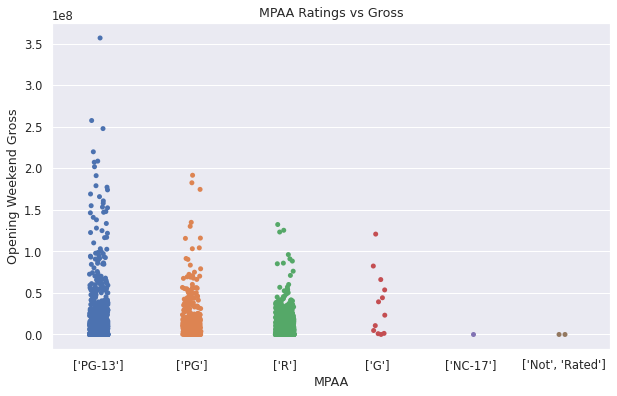

In [96]:
plt.figure(figsize=(10,6))
sns.stripplot(x='MPAA',y='Opening Weekend Gross',data=df_movies);
plt.title("MPAA Ratings vs Gross")

If the movie has a PG-13 or PG rating, it is encoded to a value of 1 in a column named **All Audience**.  
Else if it has a value of 'R', it is encoded to 1 in a column named **Adult Audience**.  
Other values are ignored.

In [97]:
df_movies['All Audience'] = df_movies.MPAA.map(lambda x: 1 if ((x=="['PG-13']") or (x=="['PG']")) else 0)
df_movies['Adult Audience'] = df_movies.MPAA.map(lambda x: 1 if x=="['R']" else 0)

df_movies.groupby(['MPAA'])[['All Audience','Adult Audience']].sum()

,All Audience,Adult Audience
MPAA,,
['G'],0,0
['NC-17'],0,0
"['Not', 'Rated']",0,0
['PG'],296,0
['PG-13'],1064,0
['R'],0,949


---
### Encoding Studio Column

The top 6 distribution studios that are most encompassing today are encoded to the number '1' under a new column named **'Big_Studio'**. If the studio is not one of these six, it is encoded to 0. 
These 6 make up almost 80% of the market share in Domestic Gross Revenue. Morever, there is a huge cliff dropoff in the market share between the 6th & 7th ranking studio (in terms of cumulative Gross Revenue).
The idea is that these bigger studios have a greater capacity to market their movies, which will help achieve a higher opening weekend revenue.   
The list of top 6 studios were taken from the site [here](https://www.the-numbers.com/market/distributors)  

The top 6 studios are:  
Walt Disney Studios Motion Pictures  
Warner Bros.  
Sony Pictures Entertainment (SPE)  
Universal Pictures  
Twentieth Century Fox  
Paramount Pictures

Walt Disney Studios Motion Pictures
Warner Bros.
Sony Pictures Entertainment (SPE)
Universal Pictures
Twentieth Century Fox
Paramount Pictures


[None, None, None, None, None, None]

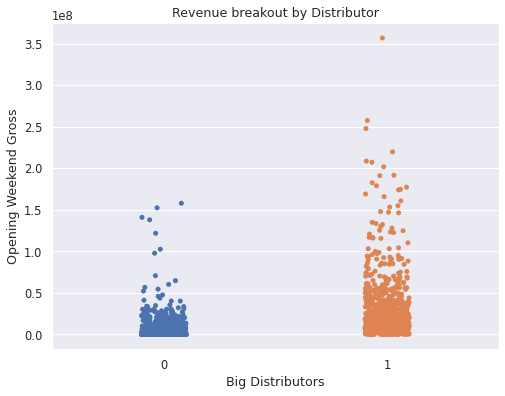

In [98]:
big_studios = ['Walt Disney Studios Motion Pictures', 'Warner Bros.', \
               'Sony Pictures Entertainment (SPE)', 'Universal Pictures', \
               'Twentieth Century Fox', 'Paramount Pictures']

df_movies['Big_Studio'] = df_movies['Studio Name'].map(lambda x:1 if x in big_studios else 0)

df_movies.head(10)

df_movies[df_movies.Big_Studio == 0].sort_values(by=y,ascending=False).head(25)
plt.figure(figsize=(8,6))
sns.stripplot(x='Big_Studio',y=y,data=df_movies)

plt.xlabel("Big Distributors")
plt.title("Revenue breakout by Distributor")
[print(studio) for studio in big_studios]

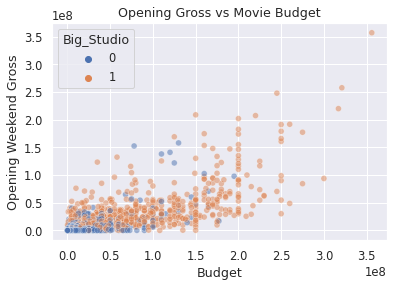

In [108]:
sns.scatterplot(x='Budget',y='Opening Weekend Gross',data=df_movies,hue='Big_Studio', alpha=0.5)
plt.title('Opening Gross vs Movie Budget');

---
### Encoding the Release Dates

There are two columns that will be created to encode the release dates.  
The first is creating a column named **'Blockbuster_Season'**. November, December, May, June & July are known as blockbuster seasons, when tentpole movies with higher commercial expectations are released. These months will be coded as a 1 for this column.
Whereas, Jan, Feb, Aug, Sep are known as **'Dump_Seasons'**. These months will be coded as a 1 for this column.

<AxesSubplot:xlabel='Dump_Season', ylabel='Opening Weekend Gross'>

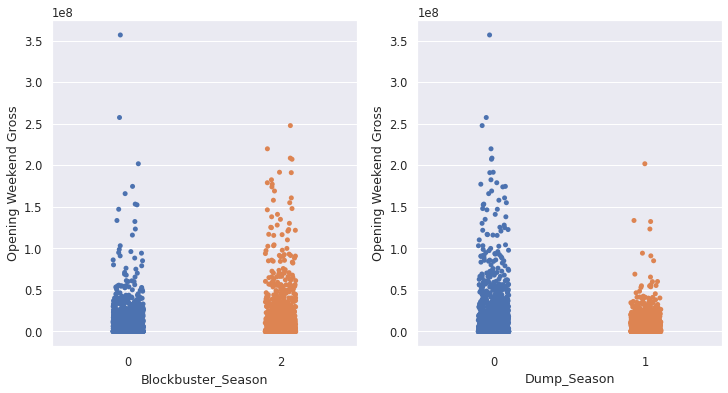

In [99]:
# Encode date to month seasonality columns
blockbuster_month_category_map = {1:0,2:0,3:0,4:0,5:2,6:2,7:2,8:0,9:0,10:0,11:2,12:2}
dump_month_category_map = {1:1,2:1,3:0,4:0,5:0,6:0,7:0,8:1,9:1,10:0,11:0,12:0}
# df_movies['Release Date'].dt.month.map(release_month_category_map)

df_movies['Blockbuster_Season'] = df_movies['Release Date'].dt.month.map(blockbuster_month_category_map)
# df_movies
df_movies['Dump_Season'] = df_movies['Release Date'].dt.month.map(dump_month_category_map)
fig,ax = plt.subplots(1,2,figsize=(12,6))
sns.stripplot(x='Blockbuster_Season',y='Opening Weekend Gross',data=df_movies,ax=ax[0])
sns.stripplot(x='Dump_Season',y='Opening Weekend Gross',data=df_movies,ax=ax[1])


Encoding the months into a single column based on release seasons, allowing for a visual study of the difference in Opening Weekend Gross based on the aforementioned factor.

Text(0.5, 0, 'Release Season')

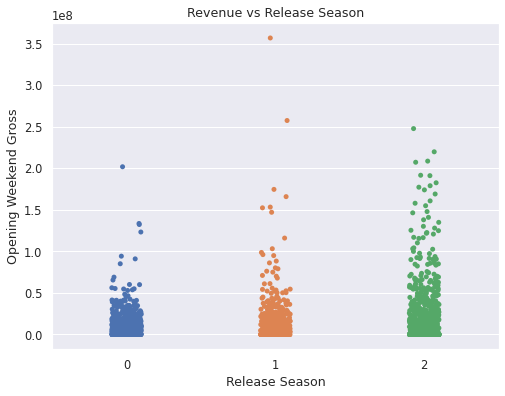

In [100]:
# Encode date to month seasonality columns
release_season_category_map = {1:0,2:0,3:1,4:1,5:2,6:2,7:2,8:0,9:0,10:1,11:2,12:2}


df_movies['Release_Season'] = df_movies['Release Date'].dt.month.map(release_season_category_map)

plt.figure(figsize=(8,6))
sns.stripplot(x='Release_Season',y='Opening Weekend Gross',data=df_movies)
plt.title("Revenue vs Release Season")
plt.xlabel("Release Season")


Additionally, a column named **'Years Since'** will be made, that calculates the number of years it's been for each movie since the minimum year of a movie in the dataset. This should help account for inflation based rise in Gross numbers. 

In [101]:
df_movies['Years Since'] = df_movies['Release Date'].dt.year - df_movies['Release Date'].dt.year.min()
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Release Link               2324 non-null   object        
 1   Title                      2324 non-null   object        
 2   Domestic Gross             2324 non-null   int64         
 3   Max Theatres               2324 non-null   object        
 4   Opening Weekend Gross      2324 non-null   int64         
 5   Domestic to Opening Gross  2324 non-null   float64       
 6   Opening Weekend Theatres   2324 non-null   int64         
 7   Release Date               2324 non-null   datetime64[ns]
 8   Studio Link                2324 non-null   object        
 9   Studio Name                2324 non-null   object        
 10  Title ID                   2324 non-null   object        
 11  Running Length             2286 non-null   float64       
 12  Budget

#### Saving the cleaned & encoded data to a csv file

In [102]:
cols_list = df_movies.drop(columns='Opening Weekend Gross').columns.tolist()+['Opening Weekend Gross']

df_movies.to_csv('Movies_List_v4.csv',index=False)

---
### Franchise

          Opening Weekend Gross               Budget              
                          count          mean  count          mean
Franchise                                                         
0.0                        1939  6.663213e+06   1939  2.474785e+07
1.0                         385  4.983351e+07    385  9.198442e+07


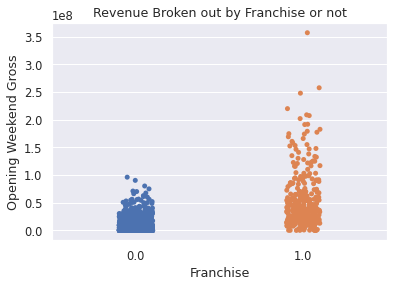

In [104]:
print(df_movies.groupby('Franchise')[['Opening Weekend Gross','Budget']].agg(['count','mean']))

sns.stripplot(x='Franchise',y = 'Opening Weekend Gross',data=df_movies)
plt.title("Revenue Broken out by Franchise or not");
plt.savefig("Franchise Breakout")

Looks like almost 8% of the movies belong to a franchise; which is great!  
Not too much of the dataset has that variable as 1, hence the column could be helpful in differentiating the prediction.  
Additionally, it is quite evident that on average, Franchise movies earn a magnitude higher than non-franchise movies  

Additionally, Franchise movies seem to have a higher budget too; indicating an interaction. Multiplying the two will definitely help!

---
### Brand

      Opening Weekend Gross               Budget              
                      count          mean  count          mean
Brand                                                         
0.0                    1973  8.827551e+06   1973  2.741426e+07
1.0                     351  4.184932e+07    351  8.350926e+07


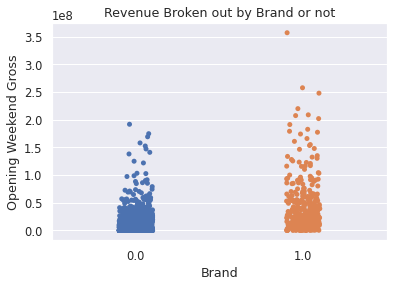

In [105]:
print(df_movies.groupby('Brand')[['Opening Weekend Gross','Budget']].agg(['count','mean']))

sns.stripplot(x='Brand',y = 'Opening Weekend Gross',data=df_movies)
plt.title("Revenue Broken out by Brand or not");
plt.savefig("Brand Breakout")

In [23]:
df_movies[df_movies.Brand == 0].sort_values(by='Opening Weekend Gross',ascending=False)

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand,Big_Studio
5177,https://www.boxofficemojo.com//release/rl33219...,The Lion King,543638043,4802,191770759,0.353,4725,2019-07-19,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt6105098,118.0,260000000.0,['PG'],"['Adventure', 'Animation', 'Drama', 'Family', ...",1.0,0.0,1
3919,https://www.boxofficemojo.com//release/rl22259...,Beauty and the Beast,504014165,4210,174750616,0.347,4210,2017-03-17,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt2771200,129.0,160000000.0,['PG'],"['Family', 'Fantasy', 'Musical', 'Romance']",1.0,0.0,1
469,https://www.boxofficemojo.com//release/rl12653...,Harry Potter and the Deathly Hallows: Part 2,381011219,4375,169189427,0.444,4375,2011-07-15,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt1201607,130.0,125000000.0,['PG-13'],"['Adventure', 'Drama', 'Fantasy', 'Mystery']",1.0,0.0,1
1562,https://www.boxofficemojo.com//release/rl26387...,The Hunger Games: Catching Fire,424668047,4163,158074286,0.372,4163,2013-11-22,https://pro.imdb.com/company/co0173285/boxoffi...,Lionsgate,tt1951264,146.0,130000000.0,['PG-13'],"['Action', 'Adventure', 'Mystery', 'Sci-Fi', '...",1.0,0.0,0
990,https://www.boxofficemojo.com//release/rl40491...,The Hunger Games,408010692,4137,152535747,0.374,4137,2012-03-23,https://pro.imdb.com/company/co0173285/boxoffi...,Lionsgate,tt1392170,142.0,78000000.0,['PG-13'],"['Action', 'Adventure', 'Sci-Fi', 'Thriller']",1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4521,https://www.boxofficemojo.com//release/rl33916...,Heart Blackened,37047,2,0,0.000,2,2017-11-10,https://pro.imdb.com/company/co0043365/boxoffi...,CJ Entertainment,tt7609180,125.0,NaN,NaN,"['Crime', 'Drama']",0.0,0.0,0
3917,https://www.boxofficemojo.com//release/rl24831...,The Hill Chris Climbed: The Gridiron Heroes Story,23487,5,0,0.000,5,2016-04-15,https://pro.imdb.com/company/co0034057/boxoffi...,Indican Pictures,tt1650549,71.0,100000.0,NaN,"['Biography', 'Documentary', 'Family', 'Sport']",0.0,0.0,0
987,https://www.boxofficemojo.com//release/rl32785...,Ra.One,2511689,189,0,0.000,189,2011-10-26,https://pro.imdb.com/company/co0050176/boxoffi...,Eros International,tt1562871,156.0,24000000.0,NaN,"['Action', 'Adventure', 'Sci-Fi']",0.0,0.0,0
986,https://www.boxofficemojo.com//release/rl33285...,Murder 2,59000,26,0,0.000,26,2011-07-08,https://pro.imdb.com/company/co0050176/boxoffi...,Eros International,tt1918965,127.0,NaN,NaN,"['Action', 'Crime', 'Drama', 'Horror', 'Thrill...",0.0,0.0,0


Just like Franchise, looks like almost 7% of the movies belong to a franchise; which is great!  
Not too much of the dataset has that variable as 1, hence the column could be helpful in differentiating the prediction.
Also, Brand movies also earn earn a magnitude higher than non-Brand movies.

---
### Opening Weekend Theatres

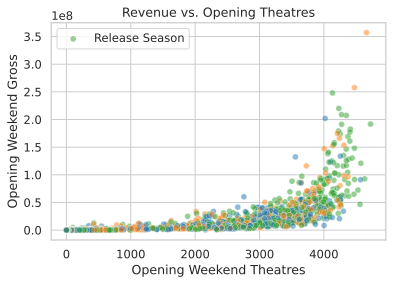

In [40]:
sns.scatterplot(x= Opening Weekend Theatres',y='Opening Weekend Gross',hue='Release_Season',\
                data=df_movies,alpha=0.5,palette='tab10')
plt.l
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Revenue vs. Opening Theatres")
plt.savefig("Revenue & Theatres")

**'Opening Weekend Theatres'** has a higher polynomial relation to the target variable. It will be engineered to the second or third degree to establih a more linear relation. 


### Change in Total Opening Weekend Gross Over Time

(2500000000.0, 3500000000.0)

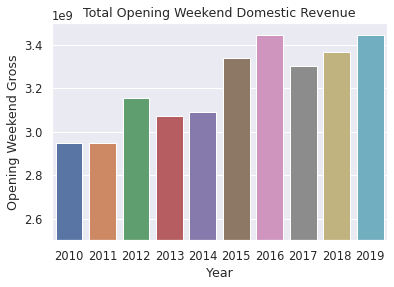

In [106]:
df_temp = df_movies.copy(deep=True)
df_temp['Year'] = (2010 + df_temp['Years Since']).astype('string')

df_temp = df_temp.groupby('Year',as_index=False)['Opening Weekend Gross'].sum()

df_temp
sns.barplot(x='Year',y='Opening Weekend Gross', data=df_temp, )
plt.title("Total Opening Weekend Domestic Revenue")
plt.ylim((2.5e9,3.5e9))